# Country-level Analysis of beyond-GDP Metrics

In [1]:
# Stdlib imports
from pathlib import Path
from itertools import combinations

# 3rd party imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## WISE data analysis with Focus on Switzerland

In [2]:
# Set up file paths
data_root = Path("../../data")
wisedb_path = data_root / "WISE/Data/WISE_Database/"

In [3]:
# Read the WISE database into memory
wise_db = dict()

for sheet in ["Content", "Metrics Info", "C Data", "CG Data", "Metrics C&CG", "C&CG Code"]:
    wise_db[sheet] = pd.read_excel(wisedb_path / "WISE_Database.xlsx", sheet_name=sheet)

In [4]:
# Filter data for Switzerland (ISO3 = "CHE")
wise_ch = wise_db["C Data"].loc[wise_db["C Data"]["ISO3"].values == "CHE"]

In [5]:
wise_ch

,ISO3,Acronym,Year,Value,Unit
166,CHE,CLIO-CMW,1820,-0.052196,Index
359,CHE,CLIO-CMW,1830,-0.113985,Index
552,CHE,CLIO-CMW,1840,0.508419,Index
745,CHE,CLIO-CMW,1850,0.505304,Index
938,CHE,CLIO-CMW,1860,0.580302,Index
...,...,...,...,...,...
1028821,CHE,WHR-LS-SS,2019,0.948513,Index (0-1)
1028822,CHE,WHR-LS-SS,2020,0.946316,Index (0-1)
1028823,CHE,WHR-LS-SS,2021,0.934393,Index (0-1)
1028824,CHE,WHR-LS-SS,2022,0.880787,Index (0-1)


In [6]:
# Split dataframe into dictionary of dataframes. Each key-value pair belongs to a specific indicator
wise_ch_ind__raw = dict()

for acr in wise_ch["Acronym"].unique():
    wise_ch_ind__raw[acr] = wise_ch.loc[wise_ch["Acronym"]==acr]

# Current number of indicators
len(wise_ch_ind__raw.keys())

238

### Data Cleaning

#### Step 1: Ignore indices that have not been recorded in at least 10 years (i.e. 10 data points)

In [7]:
wise_ch_ind__statrel = ({k: v for (k,v) in wise_ch_ind__raw.items() if len(v["Year"])>=10})

# Current number of indicators
len(wise_ch_ind__statrel.keys())

226

In [8]:
# Removed indicators
set(wise_ch_ind__raw.keys()) - set(wise_ch_ind__statrel.keys())

{'CLIO-CMW-HEIGHT',
 'WB-WDI-EN-BIR-THRD-NO',
 'WB-WDI-EN-FSH-THRD-NO',
 'WB-WDI-EN-HPT-THRD-NO',
 'WB-WDI-EN-MAM-THRD-NO',
 'WB-WDI-ER-LND-PTLD-ZS',
 'WB-WDI-GB-XPD-RSDV-GD-ZS',
 'WB-WDI-HD-HCI-OVRL',
 'WB-WDI-SE-PRM-CUAT-ZS',
 'WB-WDI-SH-PRV-SMOK',
 'WB-WDI-SM-POP-TOTL-ZS',
 'WB-WDI-SP-POP-SCIE-RD-P6'}

#### Step 2: Ignore constant indices

In [9]:
wise_ch_ind__nonconst = ({k: v for (k,v) in wise_ch_ind__statrel.items() if v["Value"].std()>0})

# Current number of indicators
len(wise_ch_ind__nonconst.keys())

200

In [10]:
# Removed indicators
set(wise_ch_ind__statrel.keys() - set(wise_ch_ind__nonconst.keys()))

{'CLIO-CMW-POLITY2',
 'FAN-DEF-EC-CO2-THRES',
 'FAN-DEF-SF-DQ-THRES',
 'FAN-DEF-SF-ED-THRES',
 'FAN-DEF-SF-EM-THRES',
 'FAN-DEF-SF-EN',
 'FAN-DEF-SF-EN-RATIO',
 'FAN-DEF-SF-EN-THRES',
 'FAN-DEF-SF-EQ-THRES',
 'FAN-DEF-SF-IN-RATIO',
 'FAN-DEF-SF-IN-THRES',
 'FAN-DEF-SF-LE-THRES',
 'FAN-DEF-SF-LS-THRES',
 'FAN-DEF-SF-NU-THRES',
 'FAN-DEF-SF-SA-RATIO',
 'FAN-DEF-SF-SA-THRES',
 'FAN-DEF-SF-SS-THRES',
 'WB-CWON-NCA-FISH-PC',
 'WB-CWON-NCA-FISH-TO',
 'WB-CWON-NCA-MANG-PC',
 'WB-CWON-NCA-MANG-TO',
 'WB-CWON-NCA-SACO-PC',
 'WB-CWON-NCA-SACO-TO',
 'WB-CWON-NCA-SAOI-PC',
 'WB-CWON-NCA-SAOI-TO',
 'WB-WDI-EG-ELC-ACCS-ZS'}

### Step 3: Split by capital

In [91]:
four_capitals = ["Human", "Social", "Natural", "Economic"]

In [11]:
capital_map = {"Human": list(wise_db["Metrics Info"].loc[wise_db["Metrics Info"]["Wellbeing"] == "X", "Acronym"].values),
               "Social": list(wise_db["Metrics Info"].loc[wise_db["Metrics Info"]["Inclusion"] == "X", "Acronym"].values),
               "Natural": list(wise_db["Metrics Info"].loc[wise_db["Metrics Info"]["Sustainability"] == "X", "Acronym"].values),
               "Economic": list(wise_db["Metrics Info"].loc[wise_db["Metrics Info"]["Economy and Society"] == "X", "Acronym"].values)
              }

In [12]:
wise_ch_by_capitals = dict()

for cap in four_capitals:
    wise_ch_by_capitals[cap] = {k: v for (k,v) in wise_ch_ind__nonconst.items() if k in capital_map[cap]}

In [13]:
# Find minimal and maximal recording year per capital
year_ranges = dict()

for cap in four_capitals:
    [min_years, max_years] = list(zip(*[(df["Year"].min(), df["Year"].max()) for _, df in wise_ch_by_capitals[cap].items()]))
    year_ranges[cap] = range(min(min_years), max(max_years)+1)

In [79]:
wise_capitals_ch = dict()

for cap in four_capitals:
    df = pd.DataFrame(index=wise_ch_by_capitals[cap].keys(), columns=[y for y in year_ranges[cap]])
    
    for index in df.index:
        for year in df.columns:
            current = wise_ch_by_capitals[cap][index]
            val = current.loc[current["Year"]==year, "Value"]
            if len(val)>0:
                df.loc[index, year] = val.values[0]

    wise_capitals_ch[cap] = df

#### Step 4: Remove years with no data

In [21]:
for cap in four_capitals:
    wise_capitals_ch[cap].dropna(axis="columns", how="all", inplace=True)

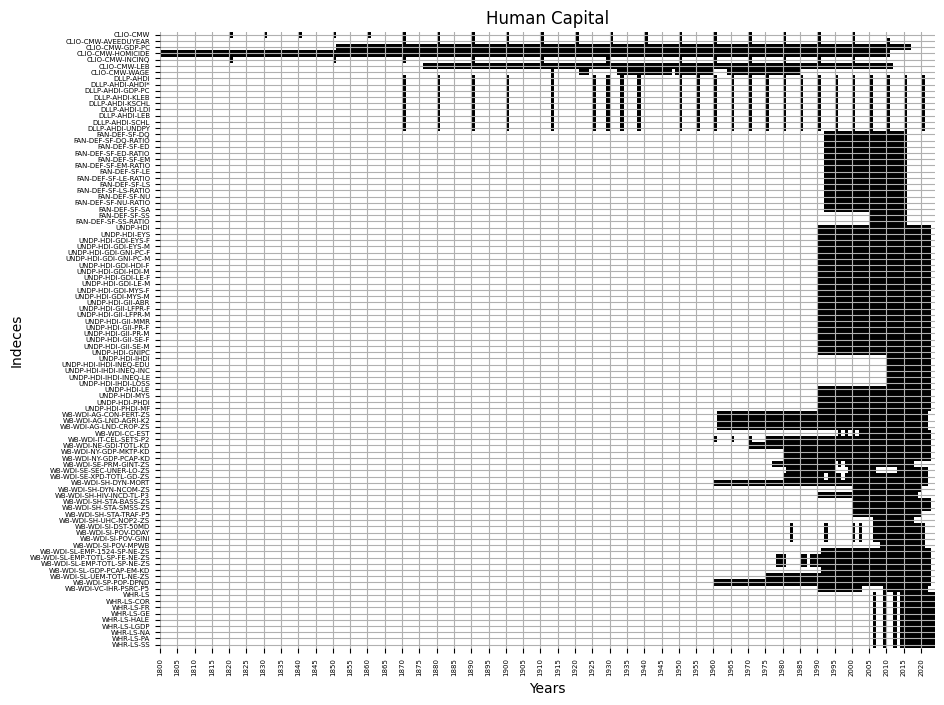

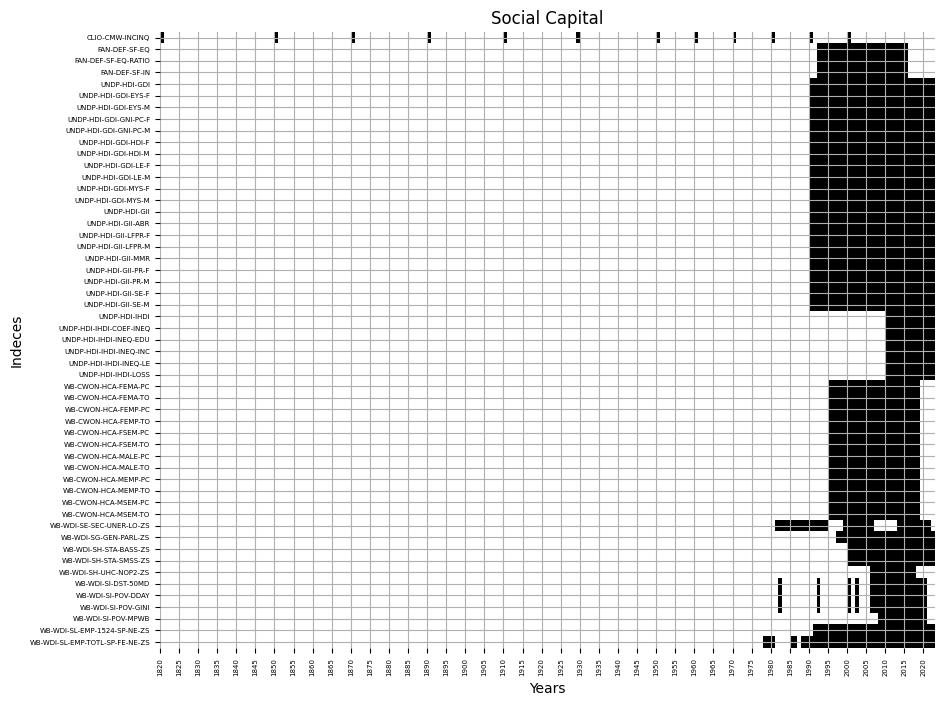

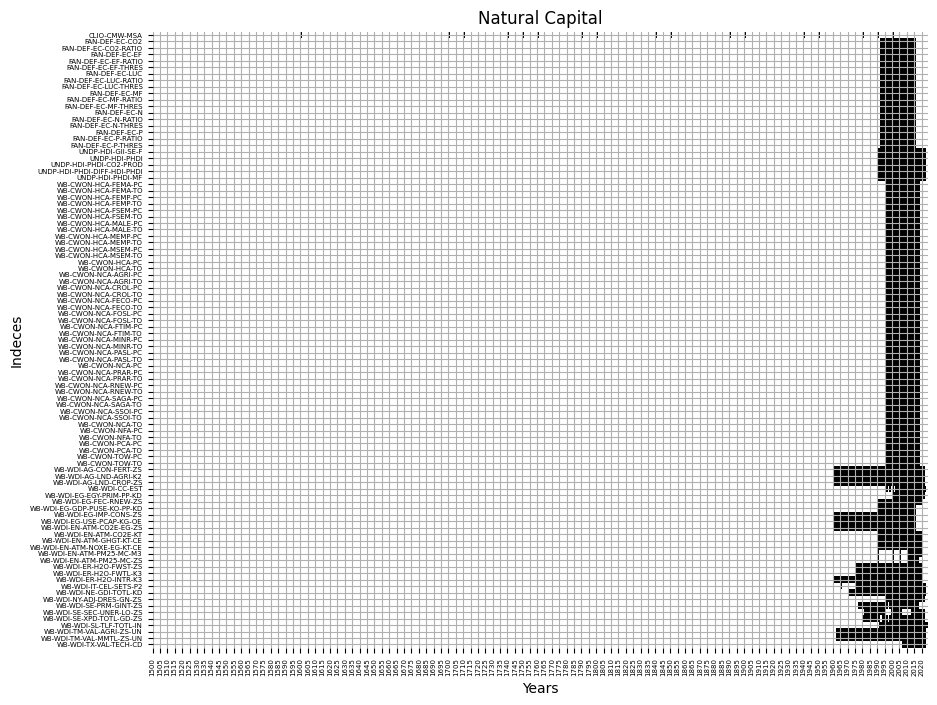

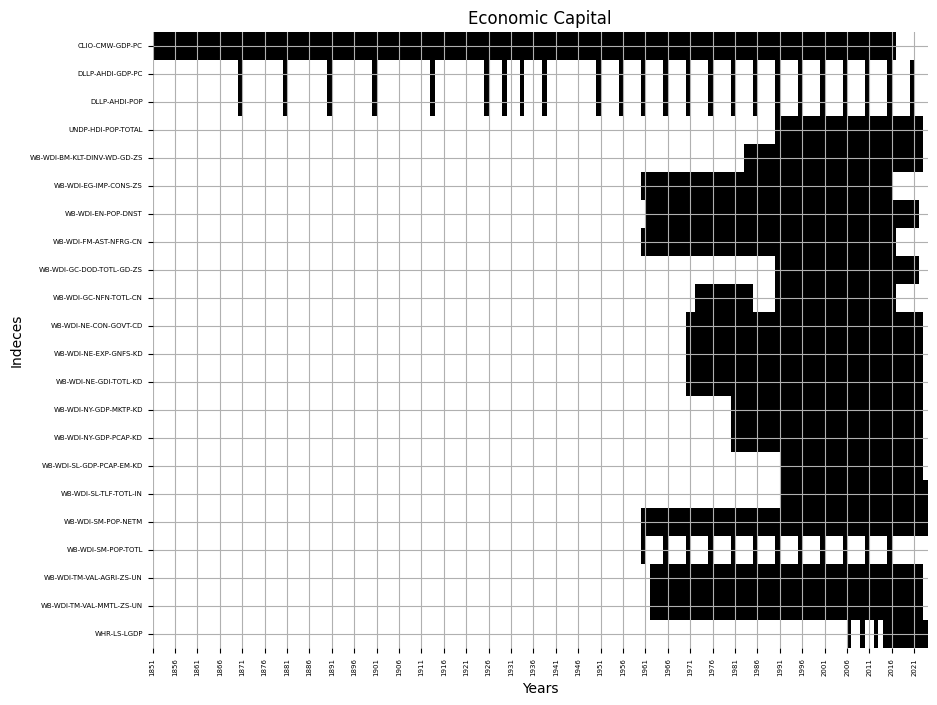

In [84]:
for cap in four_capitals:
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(wise_capitals_ch[cap].isnull(), 
                cbar=False,        # Hide color bar
                cmap=['black', 'white'],  # black = not null, white = null
                yticklabels=True)
    
    plt.grid(True)
    plt.xticks(range(0,max(wise_capitals_ch[cap].columns)-min(wise_capitals_ch[cap].columns),5), 
               [y for y in wise_capitals_ch[cap].columns][::5], fontsize=5)
    plt.yticks(fontsize=5)
    plt.xlabel("Years")
    plt.ylabel("Indeces")
    plt.title(cap + " Capital")
    fig.savefig("./valueAvailabilityMap_" + cap + "Capital.pdf")

Looking at these graphics it becomes evident that the data availability is quite good after starting in the year 1995. For this reason, I shall interpolate metrics wherever possible in order to maximize the data availability between 1995 and 2025. Then, this is the time window I focus on in the subsequent analysis.

Obviously, this strategy ignores a number of metrics. In the future, one could think of finding other time windows where ignored metrics could be correlated with metrics that have been taken into account in order to get a sense of whether those metrics contain relevant information content or not.

### Step 5: Removing metrics with insufficient availability

In [94]:
# Remove indicators with no data whatsoever prior to 1995
wise_capitals_ch_reduced = dict()

for cap in four_capitals:
    wise_capitals_ch_reduced[cap] = wise_capitals_ch[cap].copy()
    tmp = wise_capitals_ch_reduced[cap].loc[:,wise_capitals_ch_reduced[cap].columns < 1995].dropna(axis="rows", how="all")
    wise_capitals_ch_reduced[cap] = wise_capitals_ch[cap].loc[wise_capitals_ch[cap].index.isin(tmp.index),:]

### Step 6: Interpolation of metrics

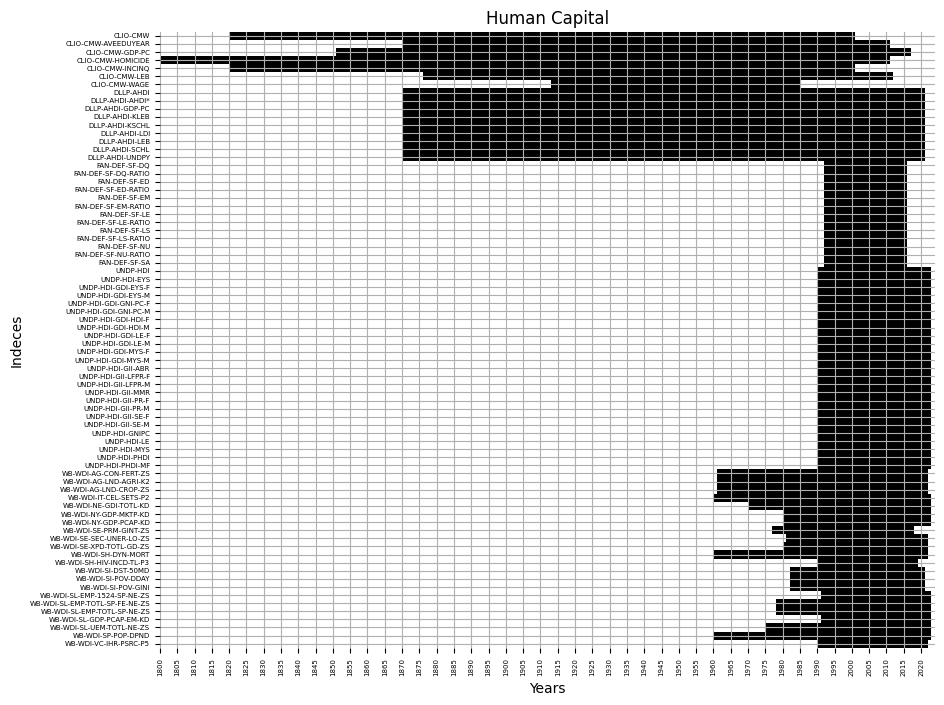

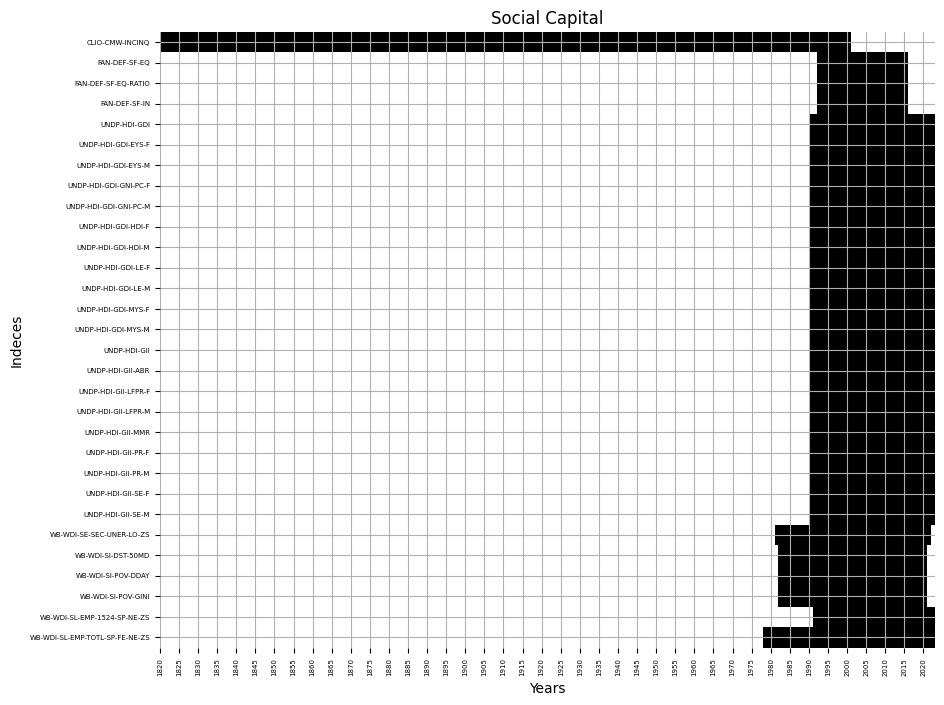

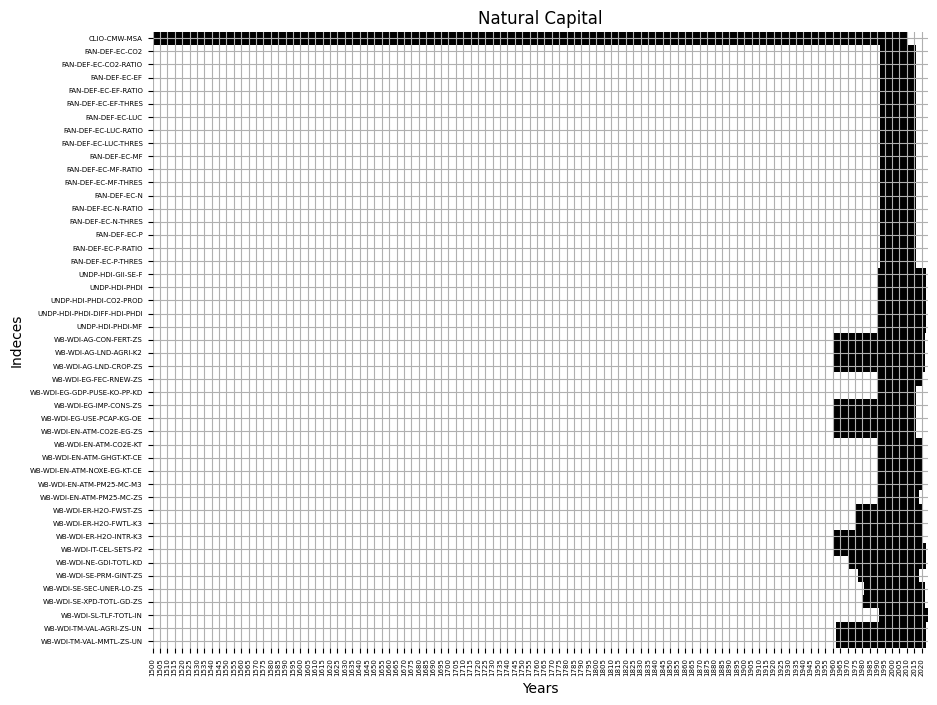

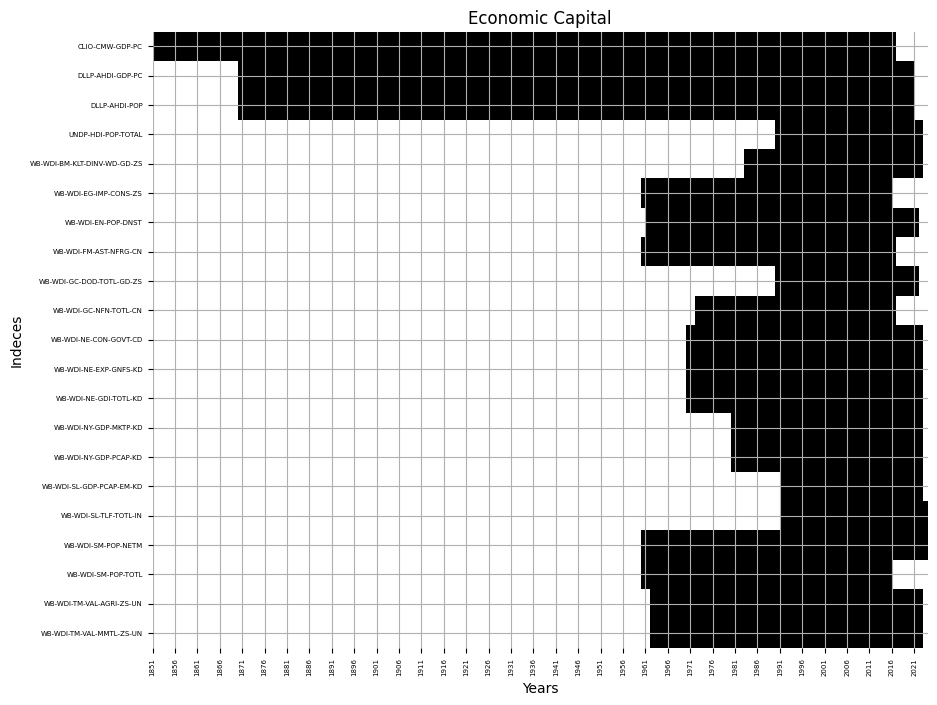

In [138]:
# Interpolate data between 1995 and 2025
wise_capitals_ch_interp = dict()

for cap in four_capitals:
    wise_capitals_ch_interp[cap] = wise_capitals_ch_reduced[cap]\
                                        .astype(float)\
                                        .interpolate("linear",axis="columns", limit_area="inside")
    
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(wise_capitals_ch_interp[cap].isnull(), 
                cbar=False,        # Hide color bar
                cmap=['black', 'white'],  # black = not null, white = null
                yticklabels=True)
    
    plt.grid(True)
    plt.xticks(range(0,max(wise_capitals_ch_reduced[cap].columns)-min(wise_capitals_ch_reduced[cap].columns),5), 
               [y for y in wise_capitals_ch_reduced[cap].columns][::5], fontsize=5)
    plt.yticks(fontsize=5)
    plt.xlabel("Years")
    plt.ylabel("Indeces")
    plt.title(cap + " Capital")
    fig.savefig("./valueAvailabilityMap_" + cap + "Capital__afterInterpolation.pdf")

### Step 7: Remove Metrics That are missing values between 1995 and 2025

In [163]:
wise_capitals_ch_clean = dict()

for cap in four_capitals:
    time_window = [a and b for (a,b) in zip(wise_capitals_ch_interp[cap].columns>=1995, 
                                            wise_capitals_ch_interp[cap].columns<=2020)
                  ]
    wise_capitals_ch_clean[cap] = wise_capitals_ch_interp[cap].loc[:, time_window].dropna(axis="rows", how="any")

### Sanity check:

In [164]:
print("Are there any NULL values left?")
for cap in four_capitals:
    print(f"{cap}: {wise_capitals_ch_clean[cap].isnull().any().any()}")

Are there any NULL values left?
Human: False
Social: False
Natural: False
Economic: False


In [165]:
n_metrics = 0
for cap in four_capitals:
    n_metrics += wise_capitals_ch_clean[cap].shape[0]

n_metrics

118

## Correlation analysis within Capitals

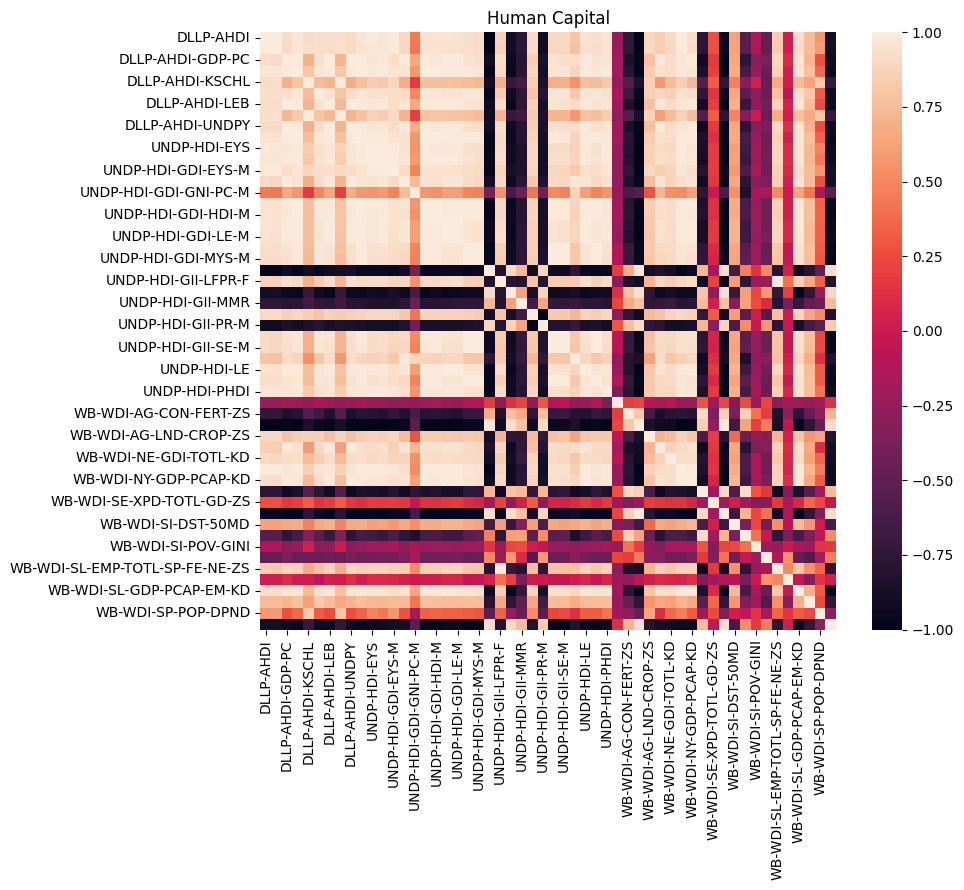

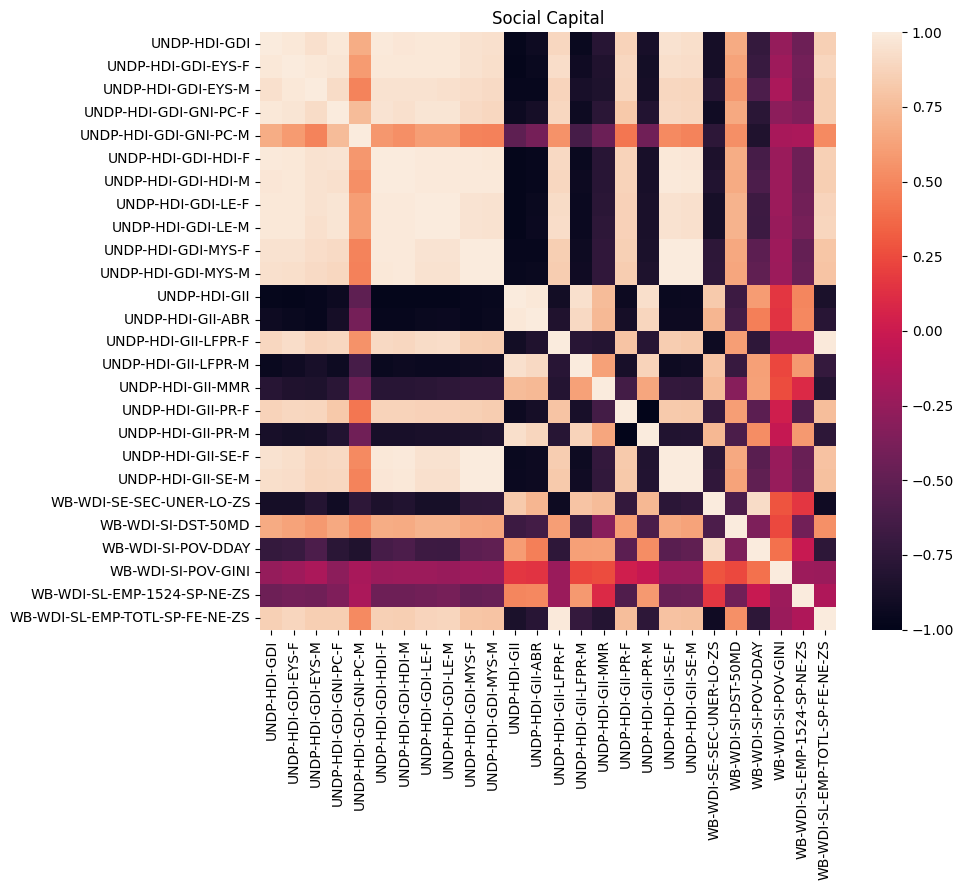

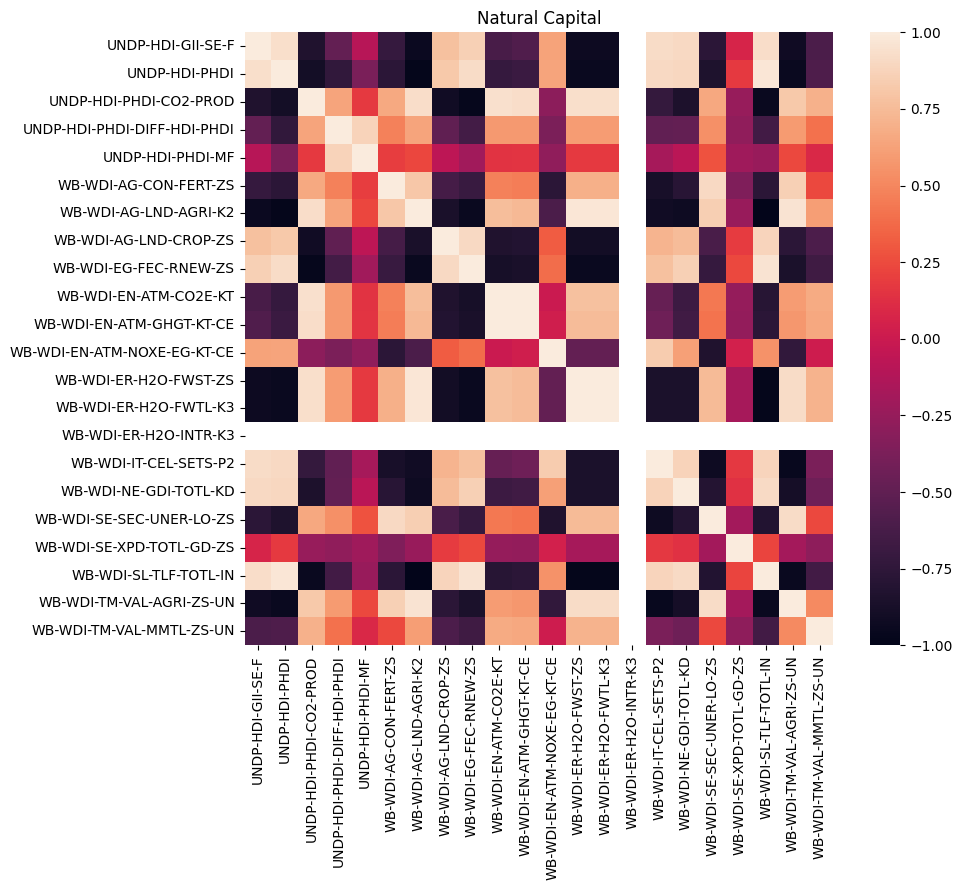

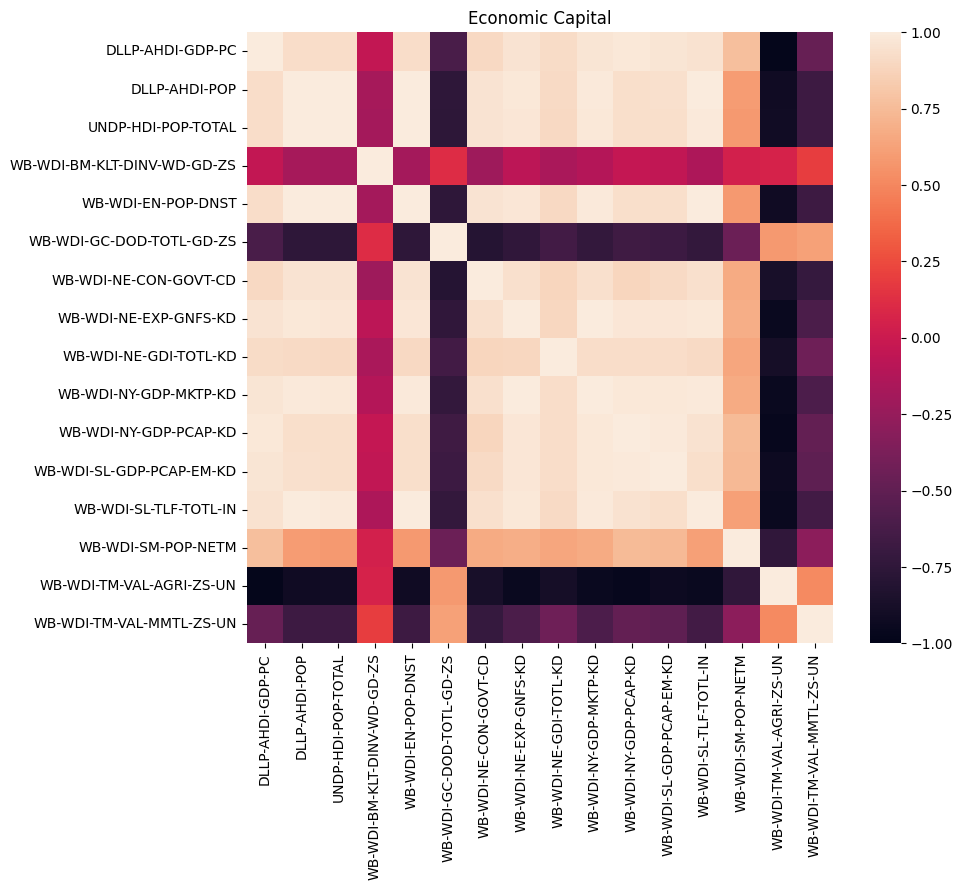

In [195]:
corr_matrices = dict()

for cap in four_capitals:
    corr_matrices[cap] = wise_capitals_ch_clean[cap].transpose().corr()
    
    fig, ax = plt.subplots(figsize=(10,9))
    sns.heatmap(corr_matrices[cap], vmin=-1, vmax=1, ax=ax)
    ax.set_title(cap + " Capital")
    plt.tight_layout()
    fig.savefig("./corrMat_" + cap + "Capital.pdf")

In [197]:
wise_capitals_ch_clean["Natural"].loc["WB-WDI-ER-H2O-INTR-K3",:]

1995    40.4
1996    40.4
1997    40.4
1998    40.4
1999    40.4
2000    40.4
2001    40.4
2002    40.4
2003    40.4
2004    40.4
2005    40.4
2006    40.4
2007    40.4
2008    40.4
2009    40.4
2010    40.4
2011    40.4
2012    40.4
2013    40.4
2014    40.4
2015    40.4
2016    40.4
2017    40.4
2018    40.4
2019    40.4
2020    40.4
Name: WB-WDI-ER-H2O-INTR-K3, dtype: float64

In [234]:
# For each capital, filter which indices to keep and which ones to drop

keepers = dict()
droppers = dict()

for cap in four_capitals:
    indices = corr_matrices[cap].index
    keepers[cap] = []
    droppers[cap] = []
    for (i1, i2) in combinations(indices,2):
        keepers[cap].append(i1)
        if np.abs(corr_matrices[cap].loc[i1,i2])>0.9:
            droppers[cap].append(i2)

    droppers[cap] = set(droppers[cap])
    keepers[cap] = list(set(keepers[cap]) - droppers[cap])

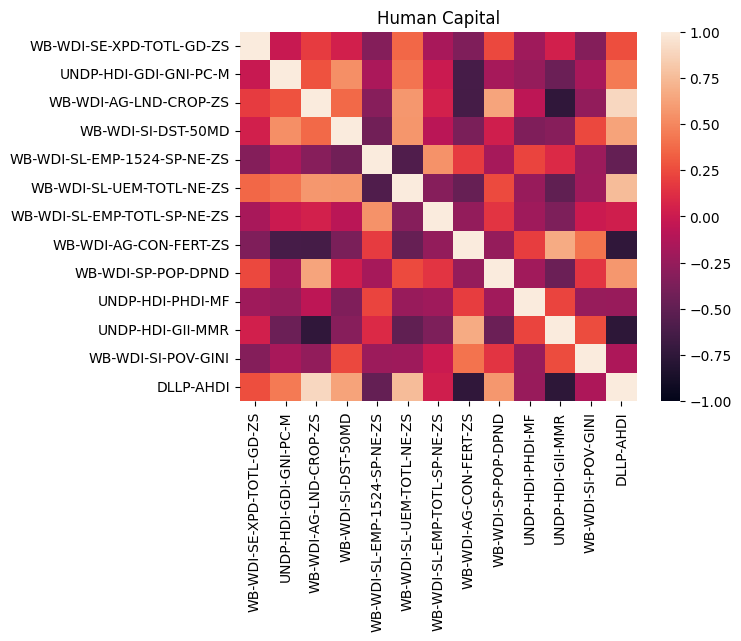

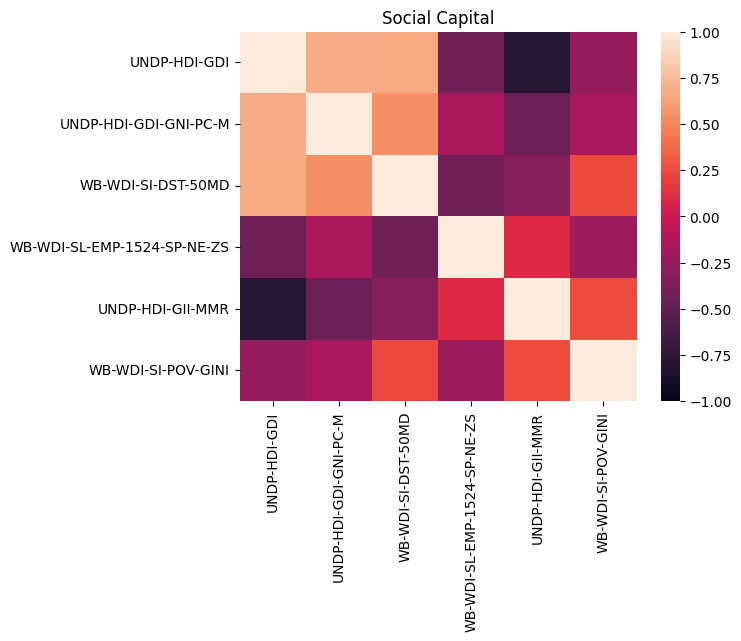

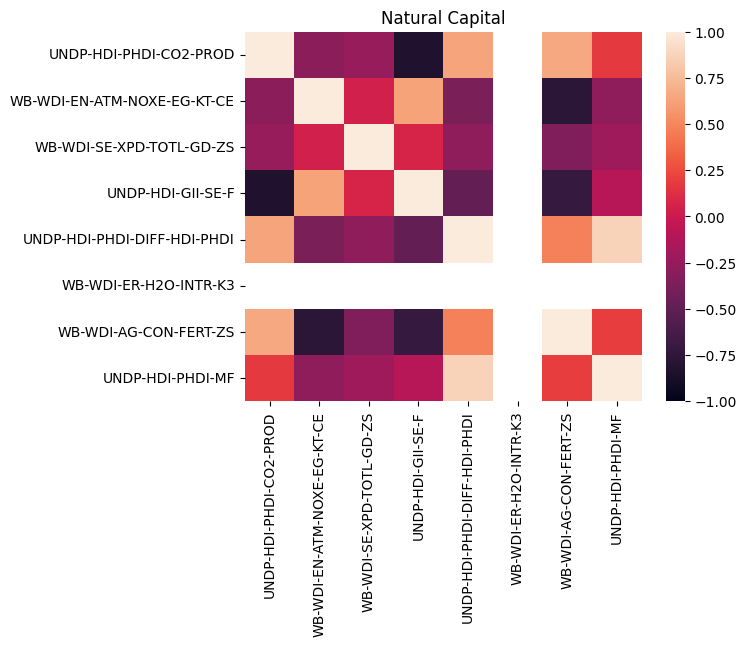

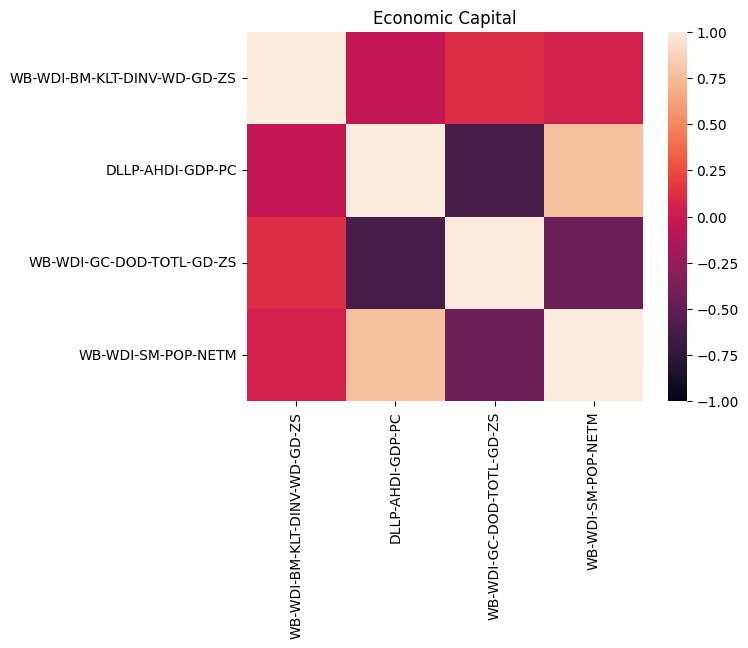

In [241]:
for cap in four_capitals:
    sns.heatmap(corr_matrices[cap].loc[keepers[cap], keepers[cap]], vmin=-1, vmax=1)
    plt.title(cap + " Capital")
    plt.show()

## Principal Component Analysis

In [242]:
from sklearn.decomposition import PCA

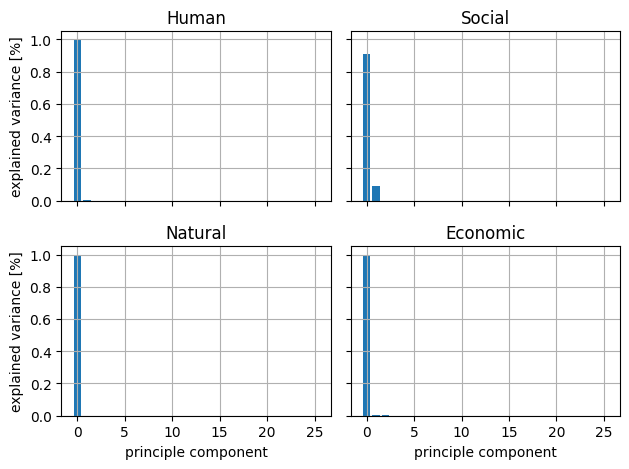

In [281]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)

pcas = dict()
for c, cap in enumerate(four_capitals):    
    n_samples = len(wise_capitals_ch_clean[cap].columns)
    n_features = len(wise_capitals_ch_clean[cap].index)
    pcas[cap] = PCA(n_components=min(n_samples, n_features))
    pcas[cap].fit(wise_capitals_ch_clean[cap].transpose())
    ev = pcas[cap].explained_variance_ratio_

    ax = axs[c//2, c%2]
    ax.bar(x=range(len(ev)), height=ev)
    ax.set_title(cap)
    ax.grid(True)
    
axs[1,0].set_xlabel("principle component")
axs[1,1].set_xlabel("principle component")
axs[1,0].set_ylabel("explained variance [%]")
axs[0,0].set_ylabel("explained variance [%]")
plt.tight_layout()
plt.show()

In [306]:
for cap in four_capitals:
    pc1 = pcas[cap].components_[0]
    axis = np.zeros_like(pc1)

    similarities = []

    for i in range(len(axis)):
        axis[i] = 1
        similarities.append(np.dot(pc1, axis))
        axis[i] = 0

    print(cap + ": " + wise_capitals_ch_clean["Human"].index[np.argmax(similarities)])

Human: WB-WDI-NY-GDP-MKTP-KD
Social: DLLP-AHDI-KLEB
Natural: UNDP-HDI-GDI-HDI-M
Economic: DLLP-AHDI-SCHL
